Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
dir_data = "/content/gdrive/My Drive/Colab Notebooks/SML/dataset1"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

import glob, os
all_img_paths = glob.glob(os.path.join(dir_img, "*.png"))
all_mask_paths = glob.glob(os.path.join(dir_seg, "*.png"))

In [3]:
import cv2
import imageio

x = []
y = []
for i in range(len(all_img_paths)):
    img = cv2.imread(all_img_paths[i])
    img = cv2.resize(img, (224,224))
    mask_path = dir_seg + all_img_paths[i].split('/')[-1]
    img_mask = imageio.imread(mask_path)
    img_mask = cv2.resize(img_mask, (224,224))
    x.append(img)
    y.append(img_mask)

In [4]:
import numpy as np
print(np.array(y).shape)
print(np.array(x).shape)

(367, 224, 224)
(367, 224, 224, 3)


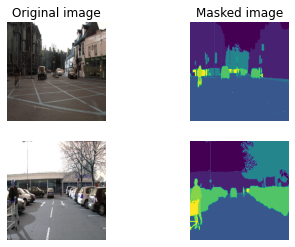

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(221)
plt.imshow(x[0])
plt.axis("off")
plt.title("Original image")
plt.grid("off")

plt.subplot(222)
plt.imshow(y[0])
plt.axis("off")
plt.title("Masked image")
plt.grid("off")

plt.subplot(223)
plt.imshow(x[1])
plt.axis("off")
plt.grid("off")

plt.subplot(224)
plt.imshow(y[1])
plt.axis("off")
plt.grid("off")
plt.show()

In [6]:
set(np.array(y).flatten())
n_classes = len(set(np.array(y).flatten()))
print(n_classes)

12


In [7]:
def getsegnum(img):
  seg_labels = np.zeros((224,224,12))
  for c in range(12):
    seg_labels[:,:,c] = (img==c).astype(int)
  return seg_labels

y2 = []
for i in range(len(y)):
  y2.append(getsegnum(y[i]))

In [8]:
x = np.array(x)/255
y2 = np.array(y2)
print(x.shape, y2.shape)
print(np.unique(y2))

(367, 224, 224, 3) (367, 224, 224, 12)
[0. 1.]


Model - UNet

In [9]:
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [10]:
def UNet(pretrained_weights = None,input_size = (224,224,3)):
    inp = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    # drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(12, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inp, outputs=[conv10])

    return model

In [ ]:
model = UNet()
model.compile(optimizer=Adam(1e-3, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy']) #class : 12개의 channel
history = model.fit(x, y2, epochs=10, batch_size=1, validation_split=0.1)

Epoch 1/10
330/330 [==============================] - 1294s 4s/step - loss: 3.5307 - accuracy: 0.5389 - val_loss: 1.0664 - val_accuracy: 0.6549
Epoch 2/10
330/330 [==============================] - 1305s 4s/step - loss: 1.0141 - accuracy: 0.6780 - val_loss: 1.0940 - val_accuracy: 0.6464
Epoch 3/10
258/330 [======================>.......] - ETA: 4:38 - loss: 0.9065 - accuracy: 0.7022

Model - UNet based pretrained VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
base_vgg16 = VGG16(input_shape = (224,224,3), include_top=False, weights="imagenet") # 학습된 모수 이용
base_vgg16.trainable = False
base_vgg16.summary()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
conv1 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block1_conv2').output).output
conv2 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block3_conv3').output).output
conv4 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block4_conv3').output).output
#drop4 = Dropout(0.5)(conv4)
conv5 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block5_conv3').output).output
#drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv5))
merge6 = concatenate([conv4, up6], axis=3) # residual connection(잔차연결)

conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
#conv6 = BatchNormalization()(conv6)

up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
merge7 = concatenate([conv3, up7], axis=3)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
#conv7 = BatchNormalization()(conv7)

up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
#conv8 = BatchNormalization()(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
#conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(12, 1, activation='softmax')(conv9)

In [ ]:
model = Model(inputs=base_vgg16.input, outputs=conv10)
for layer in model.layers[:18]:
    layer.trainable = False # 모수 고정

In [ ]:
model.compile(optimizer=Adam(1e-3, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy']) #class : 12개의 channel
history = model.fit(x, y2, epochs=10, batch_size=1, validation_split=0.1)

Model - UNet (basemodel: MobileNetV2)

In [ ]:
import tensorflow as tf
base_mobilev2 = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False, weights="imagenet")
base_mobilev2.trainable = False
base_mobilev2.summary()


Model - Basemodel : ResNet-18, ResNet-50

In [ ]:
base_resnet50 = tf.keras.applications.resnet50.ResNet50(
    input_shape = (224,224,3), include_top=False, weights='imagenet'
)
base_resnet50.trainable = False
base_resnet50.summary()

[ Data Augmentation ]

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
print(x.shape, y2.shape)

(367, 224, 224, 3) (367, 224, 224, 12)


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (x, y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
x_aug = prepare(x, shuffle=True, augment=True)


AttributeError: ignored

In [ ]:
x_aug

Prediction

In [ ]:
dir_seg_test = dir_data + "/annotations_prepped_test/"
dir_img_test = dir_data + "/images_prepped_test/"

import glob, os
all_img_paths_test = glob.glob(os.path.join(dir_img_test, "*.png"))
all_mask_paths_test = glob.glob(os.path.join(dir_seg_test, "*.png"))

In [ ]:
import cv2
import imageio

x_test = []
y_test = []
for i in range(len(all_img_paths_test)):
    img_test = cv2.imread(all_img_paths_test[i])
    img_test = cv2.resize(img_test, (224,224))
    mask_path_test = dir_seg_test + all_img_paths_test[i].split('/')[-1]
    img_mask_test = imageio.imread(mask_path_test)
    img_mask_test = cv2.resize(img_mask_test, (224,224))
    x_test.append(img_test)
    y_test.append(img_mask_test)


In [ ]:
y2_test = []
for i in range(len(y_test)):
  y2_test.append(getsegnum(y_test[i]))

x_test = np.array(x_test)/255
y2_test = np.array(y2_test)
print(x_test.shape, y2_test.shape)
print(np.unique(y2_test))

(101, 224, 224, 3) (101, 224, 224, 12)
[0. 1.]


In [ ]:
y_pred = model.predict(x_test)
y_predi = np.argmax(y_pred, axis=-1)
y_testi = np.argmax(y2_test, axis=-1)
np.mean(y_predi==y_testi)

0.8230843273262275

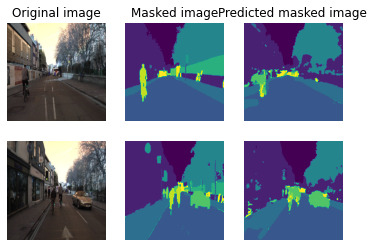

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(231)
plt.imshow(x_test[-1])
plt.axis("off")
plt.title("Original image")
plt.grid("off")

plt.subplot(232)
plt.imshow(y_test[-1])
plt.axis("off")
plt.title("Masked image")
plt.grid("off")

plt.subplot(233)
plt.imshow(y_predi[-1])
plt.axis("off")
plt.title("Predicted masked image")
plt.grid("off")

plt.subplot(234)
plt.imshow(x_test[-2])
plt.axis("off")
plt.grid("off")

plt.subplot(235)
plt.imshow(y_test[-2])
plt.axis("off")
plt.grid("off")

plt.subplot(236)
plt.imshow(y_predi[-2])
plt.axis("off")
plt.grid("off")
plt.show()